# EDiReF-subtask-III

## Setup

In [1]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False
# For colab
if IN_COLAB:
  import sys
  !git clone https://github.com/elements72/EDiReF-subtask-III.git
  %pip install lightning
  %pip install wandb
  sys.path.append('./EDiReF-subtask-III')
  %cd ./EDiReF-subtask-III
  num_workers = 2
else:
  num_workers = 0
  pass

In [2]:
import logging
log = logging.getLogger("pytorch_lightning")
log.propagate = False
log.setLevel(logging.ERROR)

In [3]:
# Reload modules, do not use cache
%load_ext autoreload
%autoreload 2

In [4]:
import pandas as pd
from pathlib import Path
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import numpy as np
from utils import train_model, hyperparameters_tuning, train_model_seeds
import torch
from baselines import random_metrics, majority_metrics, aggregate_results
from baselines import BertBaseline
from baselines import RandomUniformClassifier
from baselines import MajorityClassifier
from metrics import F1ScoreCumulative, F1ScoreDialogues
import torch
from sklearn.model_selection import train_test_split
from attention import DialoguesAttention
from lstm_model import LSTMResModel
from dataset import MeldDataModule
from bertrig import BERTrig


/home/elements72/.local/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/elements72/.local/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/home/elements72/.local/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/home/elements72/.local/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _to

Using device: cuda


/home/elements72/.local/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [5]:
# wandb is used for logging and tracking experiments
import wandb
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: antonio-lopez (nlp-ediref). Use `wandb login --relogin` to force relogin


True

# Dataset

The dataset is a modified version of the MELD dataset, it is composed by the following columns:
- emotions: each utterance has it's emotion label. The emotion types are: anger, joy, surprise, neutral, sadness, fear, disgust
- triggers: a binary value that indicates if the utterance triggers an emotion flip
- speakers: who is talking
- utterance: a single sentence in a dialogue

In [6]:
batch_size = 2
# Create and setup data module
datamodule = MeldDataModule(batch_size=batch_size, num_workers=num_workers)
datamodule.prepare_data()
datamodule.setup()
# Get dataframes
train_data = datamodule.train_data
val_data = datamodule.val_data
test_data = datamodule.test_data
# Get encoder
emotion_encoder = datamodule.emotion_encoder
#Base Dataloaders
train_loader = datamodule.train_dataloader(collate_context='sentence', batch_size=batch_size)
val_loader = datamodule.val_dataloader(collate_context='sentence', batch_size=batch_size)
test_loader = datamodule.test_dataloader(collate_context='sentence', batch_size=batch_size)

In [7]:
train_data.head(5)

,speakers,emotions,utterances,triggers
0,"[Chandler, The Interviewer, Chandler, The Inte...","[4, 4, 4, 4, 6]",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 1.0, 0.0]"
1,"[Chandler, The Interviewer, Chandler, The Inte...","[4, 4, 4, 4, 6, 4, 4]",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"
2,"[Chandler, The Interviewer, Chandler, The Inte...","[4, 4, 4, 4, 6, 4, 4, 4, 4, 4, 2]",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
3,"[Chandler, The Interviewer, Chandler, The Inte...","[4, 4, 4, 4, 6, 4, 4, 4, 4, 4, 2, 4, 6]",[also I was the point person on my company's t...,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[Joey, Rachel, Joey, Rachel]","[6, 5, 6, 2]",[But then who? The waitress I went out with la...,"[0.0, 0.0, 1.0, 0.0]"


## Dataset split
Each dialogue is composed by an arbitrary number of utterances. The dataset is divide into train/val/test, in a ratio of 80/10/10.
The split is done without shuffling the dataset. That's becuase we have several consecutive repeated dialogues (they just have a couple of utterances more or less), if we shuffle the dataset the model will have utterances in the test and val set that it has alredy saw during the train.

In [8]:
print("Train data shape: ", train_data.shape)
print("Val data shape: ", val_data.shape)
print("Test data shape: ", test_data.shape)

Train data shape:  (3200, 4)
Val data shape:  (400, 4)
Test data shape:  (400, 4)


## Dataset preprocessing
The preprocessing process is composed by:
- NaN removal in the trigger columns, the values are substitued with zeros
- Categorical encoding of the emotions


The dataloader finish the preprocessing applying the following steps:

- Dialogues padding: since the dialogues are not all of the same length we will add padding utterances to have a correct batch dimension in the sequence length. The padding value is a simple empty string.

- Utterances transformation: depending on the model that we are going to train, we can modify our utterances adding more context to them. In particular we have three modality:
    - Sentence: the current utterance is passed to the model
    - Context: the whole dialog is given with the current utterance
    - Sentence-context: like context but with the addition of another field that contains only the current utterance

It is important to underline that:
- All the utterances are prepend with the speaker name
- The dataloader creates batches at the *dialogue* level. It means that all the utterances belongng to a specific dialogue will be in the same data split and in the same batch.

Algorithm to build the context string (the [CLS] and the [EOS] token are automatically added by the BERT tokenizer):

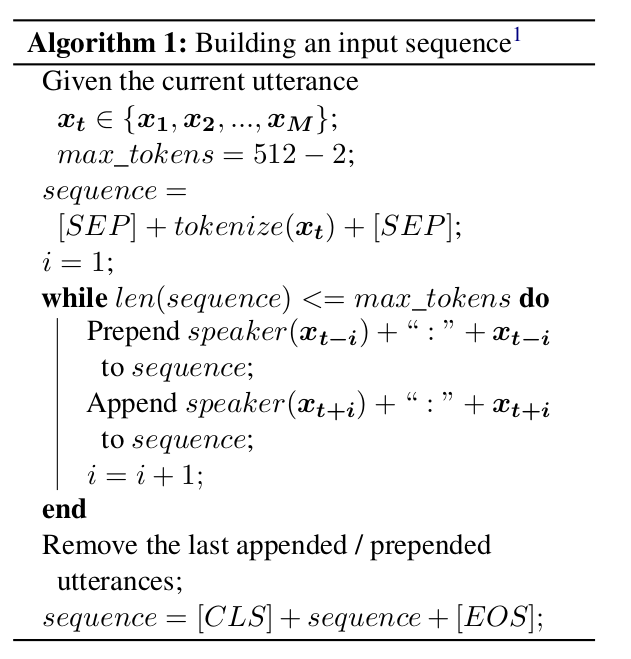

Kim, T., & Vossen, P. (2021). EmoBERTa: Speaker-Aware Emotion Recognition in Conversation with RoBERTa. ArXiv. /abs/2108.12009

In [9]:
example_loader_sentence = datamodule.val_dataloader(collate_context='sentence', batch_size=1)
example_loader_context = datamodule.val_dataloader(collate_context='context', batch_size=1)
example_loader_contexte_sentence = datamodule.val_dataloader(collate_context='context_sentence', batch_size=1)

# Get an example of the data from the dataloader
example_sentence = next(iter(example_loader_sentence))
example_context = next(iter(example_loader_context))
example_context_sentence = next(iter(example_loader_contexte_sentence))
# Print a list in new lines
print("Example sentence: ")
print("".join(example_sentence['utterances'][0][0]))
print('\n')
print("Example context: ")
print("".join(example_context['utterances'][0][0]))
print('\n')

print("Example context_sentence: ")
print("".join(example_context_sentence['utterances'][0][0]))
print('Additional context fields:')
print("".join(example_context_sentence['context'][0][0]))


Example sentence: 
Older Scientist: Dr. Geller, there's a seat over here.


Example context: 
[SEP] OLDER SCIENTIST: Dr. Geller, there's a seat over here. [SEP] ROSS: Thank you, Dr. Phillips, but I'm having my lunch at this table, here in the middle.  ROSS: I'm having lunch right here, with my good friend Joey, if he'll sit with me.  JOEY: I will sit with you Dr. Geller.  ROSS: Y'know, we work in a museum of natural history, and yet there is something unnatural about the way we eat lunch.  ROSS: Now, I look around this cafeteria, and y'know what I see, I see-I see division.  ROSS: Division, between people in white coats and people in blue blazers, and I ask myself, "My God why?!"  ROSS: Now, I say we shed these-these coats that separate us, and we get to know the people underneath.  ROSS: I'm Ross! 


Example context_sentence: 
OLDER SCIENTIST: Dr. Geller, there's a seat over here.
Additional context fields:
[SEP] OLDER SCIENTIST: Dr. Geller, there's a seat over here. [SEP] ROSS: Thank

## Data distribution
The dataset turns out to be unbalanced for emotions and triggers. Specifically in the triggers we have a huge number of **non-trigger** utterance and in the emotion most of them are **neutral**. Since class unbalance can lead our models to be unbalanced to the majority class, we will weight our loss function to give more importance to the other classes.

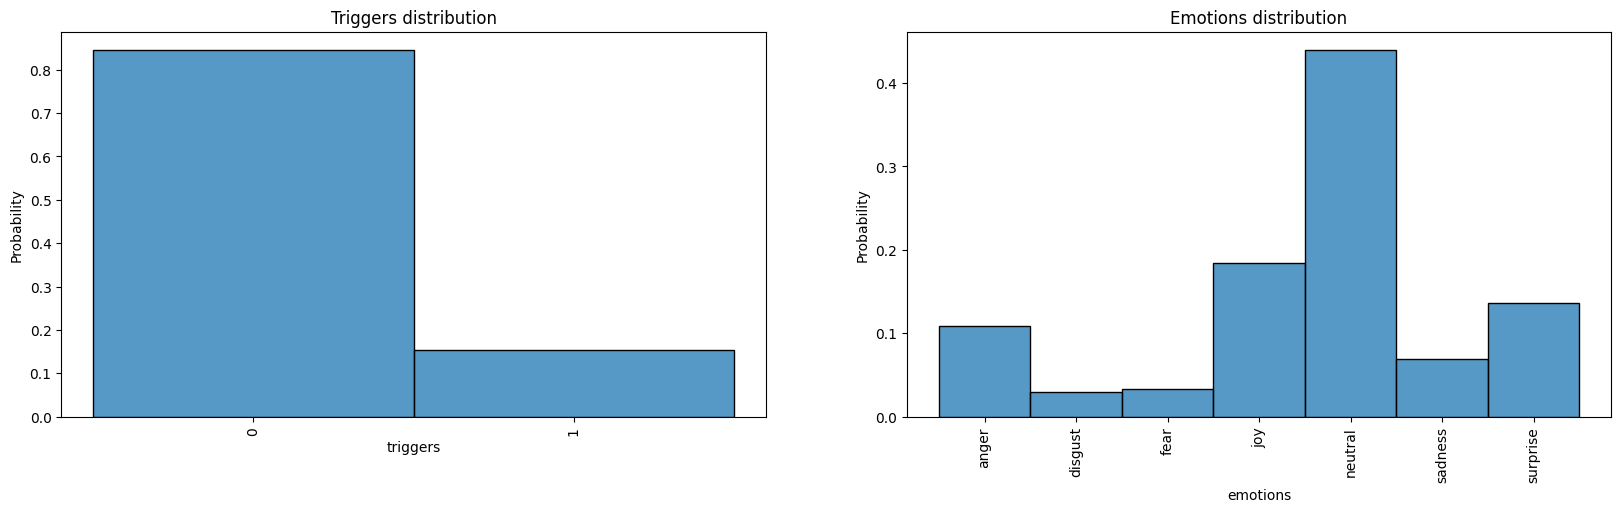

In [10]:
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
import matplotlib.pyplot as plt

class_weights_emotion = compute_class_weight('balanced', classes=np.unique(train_data['emotions'].explode()),
                                             y=train_data['emotions'].explode())
class_weights_emotion = torch.tensor(class_weights_emotion, dtype=torch.float)

class_weights_trigger = compute_class_weight('balanced', classes=np.unique(train_data['triggers'].explode()), 
                                             y=train_data['triggers'].explode())
class_weights_trigger = torch.tensor(class_weights_trigger, dtype=torch.float)

class_weights_emotion



# Plot side by side
x_labels = ["0", "1"]
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
# Trigger distribution
ax = sns.histplot(train_data['triggers'].explode(), stat='probability', discrete=True, ax=axes[0])#, x=x_labels)
ax.set_xticks(range(len(x_labels)))
ax.set_xticklabels(x_labels, rotation=90)
ax.set_title("Triggers distribution")
# Emotion distribution
x_labels = ["anger", "disgust", "fear", "joy", "neutral", "sadness", "surprise"]
ax = sns.histplot(train_data['emotions'].explode(), stat='probability', discrete=True, ax=axes[1])#, x=x_labels)
ax.set_xticks(range(len(x_labels)))
ax.set_xticklabels(x_labels, rotation=90)
ax.set_title("Emotions distribution")
plt.show()

xlabels = emotion_encoder.classes_.tolist()

## Models definition
- Baselines:
    - **Random classifier**
    - **Majority classifier**
    - **bert-freeze**: a simple bert architecture that takes in input utterances, encodes them and pass the encoding to two CLF
    - **bert-unfreeze**: same as above but BERT is also trained.
- Models:
    - **bert-lstm**: a bert model with an lstm on the top that extract global features from the dialogue. A skip connection is concatenated to the output of the LSTM before the CLF
    - **bert-attention**: same as above but with a multi-head attention.
    - **emoberta-current**: instead of bert-base-uncase we used [emoberta-large](https://huggingface.co/tae898/emoberta-base) as feature extractor. The current in the name indicates that just the current utterance is used.
    - **emoberta-lstm**: just like bert-lstm buth with emoberta
    - **bert-trig**: in this model we used two different transformers model that we called *sentence_encoder* and *context_encoder*. The *context_encoder*  for each utterance takes in input the whole dialog encoded as mentioned above in the Dataset section. The *sentence* encoder takes only the current utterance. The two outputs are concatenated and provided to the CLFs.

All this models are trained with BERT freeze and none, except for the emoberta models.

In [11]:
def get_hyperparams(model_name, freeze, lr):
    hyperparameters = {
        "lr": lr,
        "class_weights_emotion": class_weights_emotion,
        "class_weights_trigger": class_weights_trigger,
        "hidden_layers": 2,
        "use_encoder_cache": True if freeze else False,
        "encoder_cache_size": 100000,
        "freeze_bert": freeze,
        "dropout": 0.2,
        "bert_model_name": "bert-base-uncased",
        }
    if "lstm" in model_name:
        lstm_kwargs = {
            "hidden_size": 128,
            "num_layers": 2,
            "bidirectional": False,
        }
        hyperparameters["lstm_kwargs"] = lstm_kwargs
    if "emoberta" in model_name:
        hyperparameters["bert_model_name"] = "tae898/emoberta-large"
    if "bert-trig" in model_name:
        hyperparameters = {
            "lr": 1e-4,
            "class_weights_emotion": class_weights_emotion,
            "class_weights_trigger": class_weights_trigger,
            "hidden_layers": 2,
            "encoder_cache_size": 10000,
            "dropout": 0.2,
            }

    return hyperparameters


## Training
Training setup:
- **Learning rate**: 1e-5 for the unfrozen model, 1e-3 for the frozen one
- **Optimizer**: AdamW
- **Scheduler**: ReduceLROnPlateau
- **Epochs**: 20
- **Regularization**: early stopping and weight decay

The models are trained on Colab with W&B is for logging metrics and checkpoints.

In [12]:
lr = 1e-3 # Basic learning
epochs = 20
tune_hyperparameters = False
train = False
seeds = [6, 9, 42, 150, 300]

batch_size_freeze = 32
batch_size_unfreeze = 8

train_loader_freeze = datamodule.train_dataloader(collate_context='sentence', batch_size=batch_size_freeze)
val_loader_freeze = datamodule.val_dataloader(collate_context='sentence', batch_size=batch_size_freeze)
test_loader_freeze = datamodule.test_dataloader(collate_context='sentence', batch_size=batch_size_freeze)

train_loader_unfreeze = datamodule.train_dataloader(collate_context='sentence', batch_size=batch_size_unfreeze)
val_loader_unfreeze = datamodule.val_dataloader(collate_context='sentence', batch_size=batch_size_unfreeze)
test_loader_unfreeze = datamodule.test_dataloader(collate_context='sentence', batch_size=batch_size_unfreeze)

train_loader_emoberta = datamodule.train_dataloader(collate_context='sentence', batch_size=batch_size_unfreeze)
val_loader_emoberta = datamodule.val_dataloader(collate_context='sentence', batch_size=batch_size_unfreeze)
test_loader_emoberta = datamodule.test_dataloader(collate_context='sentence', batch_size=batch_size_unfreeze)



train_loader_bert_trig = datamodule.train_dataloader(collate_context='context_sentence', batch_size=1)
val_loader_bert_trig = datamodule.val_dataloader(collate_context='context_sentence', batch_size=1)
test_loader_bert_trig = datamodule.test_dataloader(collate_context='context_sentence', batch_size=1)



models = {
    "bert-baseline-freeze":{'model_class': BertBaseline, 'hyperparameters': get_hyperparams("bert-baseline-freeze", freeze=True, lr=lr), "train_loader": train_loader_freeze, "val_loader": val_loader_freeze},
    "bert-baseline-unfreeze":{'model_class': BertBaseline, 'hyperparameters': get_hyperparams("bert-baseline-unfreeze", freeze=False, lr=lr), "train_loader": train_loader_unfreeze, "val_loader": val_loader_unfreeze},
    "bert-lstm-freeze":{'model_class': LSTMResModel, 'hyperparameters': get_hyperparams("bert-lstm-freeze", freeze=True, lr=lr), "train_loader": train_loader_freeze, "val_loader": val_loader_freeze},
    "bert-lstm-unfreeze":{'model_class': LSTMResModel, 'hyperparameters': get_hyperparams("bert-lstm-unfreeze", freeze=False, lr=lr), "train_loader": train_loader_unfreeze, "val_loader": val_loader_unfreeze},
    "bert-attention-freeze":{'model_class': DialoguesAttention, 'hyperparameters': get_hyperparams("bert-attention-freeze", freeze=True, lr=lr), "train_loader": train_loader_freeze, "val_loader": val_loader_freeze},
    "bert-attention-unfreeze":{'model_class': DialoguesAttention, 'hyperparameters': get_hyperparams("bert-attention-unfreeze", freeze=False, lr=lr), "train_loader": train_loader_unfreeze, "val_loader": val_loader_unfreeze},
    "emoberta-current": {'model_class': BertBaseline, 'hyperparameters': get_hyperparams("emoberta", freeze=True, lr=lr), "train_loader": train_loader_emoberta, "val_loader": val_loader_emoberta},
    "emoberta-lstm": {'model_class': LSTMResModel, 'hyperparameters': get_hyperparams("emoberta-lstm", freeze=True, lr=lr), "train_loader": train_loader_emoberta, "val_loader": val_loader_emoberta},
    "bert-trig": {'model_class': BERTrig, 'hyperparameters': get_hyperparams("bert-trig", freeze=True, lr=lr), "train_loader": train_loader_bert_trig, "val_loader": val_loader_bert_trig},
    }

# to_train = ['emoberta']
# for model_name, model_dict in models.items():
#   if model_name not in to_train:
#     continue
#   train_model_seeds(**model_dict, model_name=model_name, seeds=seeds, epochs=epochs, wandb=wandb)

In [13]:
from utils import load_model, evaluate_model
import os

def eval(models, seeds, test=False, to_evaluate=None, load=True):
    results_path = Path("results")
    results_name = f"{'test' if test else 'val'}_results.csv"
    results = pd.DataFrame()
    # Try loading existing results
    if os.path.exists(results_path / results_name):
        results = pd.read_csv(results_path / results_name, index_col=0)
        if load:
            return results
    for model_name, model_dict in models.items():
        if to_evaluate is not None and model_name not in to_evaluate:
            continue
        if model_name == 'bert-trig':
            test_loader_evaluate = datamodule.test_dataloader(collate_context='context_sentence', batch_size=1)
            if not test:
                test_loader_evaluate = val_loader_bert_trig
        else:
            test_loader_evaluate = test_loader_unfreeze
            if not test:
                test_loader_evaluate = val_loader_unfreeze
        for seed in seeds:
            print(f"Evaluating {model_name} with seed {seed}    ")
            model = load_model(model_dict["model_class"], f"{model_name}-seed-{seed}")
            if model is None:
                continue
            result = evaluate_model(model, f"{model_name}-seed-{seed}", test_loader_evaluate, test=True, verbose=False)
            # If the model name is alreay in the results substitude it
            if f"{model_name}-seed-{seed}" in results.index:
                results.loc[model_name] = result
            else:
                results = pd.concat([results, result])
        # save results  
        results.to_csv(results_path / results_name, index=True)
    return results

## Evaluation
The models are evaluated on the validation and test set with. 
It's possible to see that the performance on both the two splits are very similar except for the *emoberta-lstm*. For this model we can see a huge difference for the emotion metrics.

A possible explanation could be how the dataset is structured. As mentioned before we have several dialogues that are repeated, for this reason if the model performs badly on some sentences this error is repeated for all the copies of the sentences. So it could probably be just bad luck but this explanation does not fully satisfy us. 

### Freeze vs unfreeze models
As we can expect the unfreeze models perform better than the counterparty in all the metrics. An exception is represented by the *bert-lstm* model. In this specific case there is a trade off between the emotions metrics and the triggers metrics.

### Emoberta vs the others
The emoberta models (*emoberta-current*, *emoberta-lstm*, *bert-trig*) show the best numbers for the emotion metrics. However it is important to mention that emoberta is pre-trained also on the MELD dataset and there is a chance that some dialogues in the val and test were also in its training set.


In [14]:
load_results = True
test_results = eval(models, seeds, test=True, load=load_results)
val_results = eval(models, seeds, test=False, load=load_results)

In [15]:
test_results = test_results.drop(columns=["test_loss", "test_emotion_loss", "test_trigger_loss"])
val_results = val_results.drop(columns=["val_loss", "val_emotion_loss", "val_trigger_loss"])

In [16]:
# Compute the mean and std on the validation results
val_results_aggregated = val_results.copy()
val_results_aggregated.index =  val_results_aggregated.index.str.replace("-seed-\d+", "")
val_results_aggregated = val_results_aggregated.groupby(level=0).agg(["mean", "std"])
val_results_aggregated

/tmp/ipykernel_4294/3603405778.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  val_results_aggregated.index =  val_results_aggregated.index.str.replace("-seed-\d+", "")


f1_val_cumulative_emotion            \
                                             mean       std   
model_name                                                    
bert-attention-freeze                    0.342568  0.026452   
bert-attention-unfreeze                  0.416598  0.013350   
bert-baseline-freeze                     0.351213  0.027555   
bert-baseline-unfreeze                   0.405052  0.009767   
bert-lstm-freeze                         0.364403  0.015630   
bert-lstm-unfreeze                       0.404498  0.013027   
bert-trig                                0.571287  0.014569   
emoberta-current                         0.518913  0.016516   
emoberta-lstm                            0.273755  0.027802   

                        f1_val_cumulative_trigger            \
                                             mean       std   
model_name                                                    
bert-attention-freeze                    0.392112  0.004216   
bert-attention-unfreeze                  0.398428  0.008319   
bert-baseline-freeze                     0.383382  0.007437   
bert-baseline-unfreeze                   0.391629  0.006359   
bert-lstm-freeze                         0.401732  0.016214   
bert-lstm-unfreeze                       0.393592  0.006693   
bert-trig                                0.369628  0.008938   
emoberta-current                         0.367841  0.009820   
emoberta-lstm                            0.370465  0.034916   

                        f1_val_cumulative_trigger_multi            \
                                                   mean       std   
model_name                                                          
bert-attention-freeze                          0.535139  0.073238   
bert-attention-unfreeze                        0.586715  0.006242   
bert-baseline-freeze                           0.439890  0.028022   
bert-baseline-unfreeze                         0.511962  0.011278   
bert-lstm-freeze                               0.581580  0.017161   
bert-lstm-unfreeze                             0.503967  0.021141   
bert-trig                                      0.499664  0.025609   
emoberta-current                               0.442162  0.036973   
emoberta-lstm                                  0.532580  0.037518   

                        f1_val_dialogues_emotion            \
                                            mean       std   
model_name                                                   
bert-attention-freeze                   0.317027  0.043175   
bert-attention-unfreeze                 0.378657  0.012671   
bert-baseline-freeze                    0.314453  0.039840   
bert-baseline-unfreeze                  0.365977  0.012251   
bert-lstm-freeze                        0.327746  0.020954   
bert-lstm-unfreeze                      0.371579  0.016756   
bert-trig                               0.539811  0.012505   
emoberta-current                        0.464493  0.030540   
emoberta-lstm                           0.257436  0.029446   

                        f1_val_dialogues_trigger            \
                                            mean       std   
model_name                                                   
bert-attention-freeze                   0.348372  0.038770   
bert-attention-unfreeze                 0.333720  0.019027   
bert-baseline-freeze                    0.394063  0.017774   
bert-baseline-unfreeze                  0.370018  0.015288   
bert-lstm-freeze                        0.351448  0.041145   
bert-lstm-unfreeze                      0.383181  0.010235   
bert-trig                               0.356833  0.019879   
emoberta-current                        0.369348  0.016836   
emoberta-lstm                           0.323446  0.079670   

                        f1_val_dialogues_trigger_multi            
                                                  mean       std  
model_name                                               

In [17]:
# Compute the mean and std on the test results
test_results_aggregated = test_results.copy()
test_results_aggregated.index =  test_results_aggregated.index.str.replace("-seed-\d+", "")
test_results_aggregated = test_results_aggregated.groupby(level=0).agg(["mean", "std"])
test_results_aggregated

/tmp/ipykernel_4294/2519587553.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  test_results_aggregated.index =  test_results_aggregated.index.str.replace("-seed-\d+", "")


f1_test_cumulative_emotion            \
                                              mean       std   
model_name                                                     
bert-attention-freeze                     0.333387  0.022827   
bert-attention-unfreeze                   0.406844  0.023510   
bert-baseline-freeze                      0.360447  0.021234   
bert-baseline-unfreeze                    0.408425  0.013422   
bert-lstm-freeze                          0.365662  0.014246   
bert-lstm-unfreeze                        0.413969  0.009863   
bert-trig                                 0.637304  0.010282   
emoberta-current                          0.566634  0.014617   
emoberta-lstm                             0.607828  0.020437   

                        f1_test_cumulative_trigger            \
                                              mean       std   
model_name                                                     
bert-attention-freeze                     0.318745  0.025600   
bert-attention-unfreeze                   0.338968  0.007902   
bert-baseline-freeze                      0.279776  0.001793   
bert-baseline-unfreeze                    0.287504  0.007836   
bert-lstm-freeze                          0.339595  0.005212   
bert-lstm-unfreeze                        0.292828  0.008305   
bert-trig                                 0.275056  0.005800   
emoberta-current                          0.275746  0.012876   
emoberta-lstm                             0.314184  0.013018   

                        f1_test_cumulative_trigger_multi            \
                                                    mean       std   
model_name                                                           
bert-attention-freeze                           0.507598  0.094494   
bert-attention-unfreeze                         0.567124  0.012692   
bert-baseline-freeze                            0.395314  0.040571   
bert-baseline-unfreeze                          0.472265  0.015174   
bert-lstm-freeze                                0.569556  0.019693   
bert-lstm-unfreeze                              0.461105  0.019580   
bert-trig                                       0.465529  0.037414   
emoberta-current                                0.425285  0.032207   
emoberta-lstm                                   0.540059  0.056881   

                        f1_test_dialogues_emotion            \
                                             mean       std   
model_name                                                    
bert-attention-freeze                    0.325227  0.048917   
bert-attention-unfreeze                  0.400479  0.016463   
bert-baseline-freeze                     0.342467  0.035196   
bert-baseline-unfreeze                   0.399961  0.017134   
bert-lstm-freeze                         0.354995  0.024368   
bert-lstm-unfreeze                       0.404116  0.026548   
bert-trig                                0.620521  0.006983   
emoberta-current                         0.538498  0.019573   
emoberta-lstm                            0.564226  0.019451   

                        f1_test_dialogues_trigger            \
                                             mean       std   
model_name                                                    
bert-attention-freeze                    0.281099  0.028775   
bert-attention-unfreeze                  0.293837  0.010580   
bert-baseline-freeze                     0.318977  0.006458   
bert-baseline-unfreeze                   0.312562  0.010616   
bert-lstm-freeze                         0.280746  0.026727   
bert-lstm-unfreeze                       0.325001  0.009811   
bert-trig                                0.292435  0.022880   
emoberta-current                         0.306650  0.024807   
emoberta-lstm                            0.256717  0.037354   

                        f1_test_dialogues_trigger_multi            
                                                   mean       s

In [18]:
emotions_classes = len(emotion_encoder.classes_)
triggers_classes = 2

# Random Classifier
# Test set
random_uniform_classifier = RandomUniformClassifier(emotions_classes, triggers_classes)
metrics_random, emotions_predictions, triggers_predictions = random_metrics(random_uniform_classifier, test_loader, num_classes_emotions=emotions_classes, num_classes_triggers=triggers_classes)
# Validation set
metrics_random_val, emotions_predictions_val, triggers_predictions_val= random_metrics(random_uniform_classifier, val_loader, num_classes_emotions=emotions_classes, num_classes_triggers=triggers_classes)


# Majority Classifier
# Test set
majority_classifier = MajorityClassifier(num_classes_emotions=emotions_classes, num_classes_triggers=triggers_classes, padding_value_emotions=emotions_classes, padding_value_triggers=triggers_classes)
majority_classifier.fit(train_loader)
metrics_majority, emotions_predictions, triggers_predictions = majority_metrics(majority_classifier, test_loader, num_classes_emotions=emotions_classes, num_classes_triggers=triggers_classes)
# Validation set
metrics_majority_val, emotions_predictions_val, triggers_predictions_val = majority_metrics(majority_classifier, val_loader, num_classes_emotions=emotions_classes, num_classes_triggers=triggers_classes)
#Resultsaggregated_results
aggregated_results = aggregate_results(metrics_random, metrics_majority, metrics_random_val, metrics_majority_val)

aggregated_results

,F1 Cumulative_Emotions,F1 Dialogues_Emotions,F1 Cumulative_Triggers_Binary,F1 Dialogues_Triggers_Binary,F1 Cumulative_Triggers_Multiclass,F1 Dialogues_Triggers_Multiclass
Random Classifier (test),0.129080,0.075364,0.212711,0.223943,0.421257,0.408850
Random Classifier (val),0.128923,0.075579,0.296060,0.287902,0.456952,0.430803
Majority Classifier (test),0.084635,0.078938,0.000000,0.000000,0.460621,0.443001
Majority Classifier (val),0.085029,0.080086,0.000000,0.000000,0.440633,0.416301


# Error analysis
Since EDiReF 2024 is about detection of emotion triggers the model with the best performance on the trigger is taken

In [50]:
# Pick best model as average of trigger and emotion


best_model_name = (test_results['f1_test_cumulative_trigger']).idxmax()
best_model_key = best_model_name.split("-seed")[0]
# Load the best model
best_model = load_model(models[best_model_key]["model_class"], best_model_name, hyperparameters=models[best_model_key]["hyperparameters"])
best_model = best_model.cpu()
best_model.eval()
# Move on cpu

print(f"Best model: {best_model_name}")

/home/elements72/.local/lib/python3.10/site-packages/lightning/pytorch/utilities/migration/utils.py:55: The loaded checkpoint was produced with Lightning v2.1.4, which is newer than your current Lightning version: v2.1.0


Best model: bert-attention-unfreeze-seed-9


In [57]:
def model_predict(loader, model):
    y_pred = {"emotions": torch.Tensor().to('cpu'), "triggers": torch.Tensor().to('cpu')}
    y_true = {"emotions": torch.empty(0, dtype=torch.long).to('cpu'), "triggers": torch.empty(0, dtype=torch.long).to('cpu')}
    for batch in loader:

        batch["emotions"].to('cpu')
        batch["triggers"].to('cpu')
        preds = model.predict(batch)
        
        
        emotions = preds["emotions"].to('cpu')
        triggers = preds["triggers"].to('cpu')

        emotions = emotions.reshape(-1, model.emotion_output_dim)
        triggers = triggers.reshape(-1, model.trigger_output_dim)

        y_pred["emotions"] = torch.cat([y_pred["emotions"], emotions])
        y_pred["triggers"] = torch.cat([y_pred["triggers"], triggers])

        y_true["emotions"] = torch.cat([y_true["emotions"], batch["emotions"].reshape(-1).to('cpu')], dim=0)
        y_true["triggers"] = torch.cat([y_true["triggers"], batch["triggers"].reshape(-1).to('cpu')], dim=0)

    return y_pred, y_true

In [55]:
import matplotlib.pyplot as plt
from torchmetrics import PrecisionRecallCurve


def plot_precision_recall(y_pred, y_true, output_dim, labels):
    ignore_index = output_dim
    precision_curve = PrecisionRecallCurve(task="multiclass", num_classes=output_dim, ignore_index=ignore_index)

    print(y_pred.shape)
    curve = precision_curve(y_pred, y_true)
    precision, recall, _ = curve

    plt.figure(figsize=(15, 10))
    plt.title("Precision-Recall Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.grid()

    emotion_to_auc = {}
    for i in range(output_dim):
        emotion = labels[i]
                
        auc = -1 * torch.trapz(precision[i], recall[i])
        
        emotion_to_auc[emotion] = auc.item()
        
        plt.plot(recall[i], precision[i], label=f"{emotion}: {auc:.2f}")

    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    plt.show()


In [52]:
if "bert-trig" in best_model_key:
    test_loader = test_loader_bert_trig
else:
    test_loader = test_loader_unfreeze

In [60]:
y_pred, y_true = model_predict(test_loader, best_model)
plot_precision_recall(y_pred["emotions"], y_true["emotions"], best_model.emotion_output_dim, emotion_encoder.classes_)
plot_precision_recall(y_pred["triggers"], y_true["triggers"], best_model.trigger_output_dim, ["0", "1"])

In [ ]:
from torchmetrics.classification import MulticlassConfusionMatrix
def plot_confusion_matrix(y_pred, y_true, labels, output_dim):
    ignore_index = output_dim

    confusion_matrix_metric = MulticlassConfusionMatrix(num_classes=best_model.emotion_output_dim, ignore_index=ignore_index).to('cpu')

    y_pred_class = torch.argmax(y_pred, dim=1)

    confusion_matrix = confusion_matrix_metric(y_pred_class, y_true)

    # plot confusion matrix
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.imshow(confusion_matrix)
    plt.colorbar()
    plt.xticks(range(ignore_index), labels)
    plt.yticks(range(ignore_index), labels)
    # Insert values in the matrix
    for i in range(ignore_index):
        for j in range(ignore_index):
            plt.text(j, i, confusion_matrix[i, j].item(), ha="center", va="center", color="white" if confusion_matrix[i, j] < 100 else "black")

    # x ticks labels vertical
    plt.xticks(rotation=90)

    plt.show()
    return confusion_matrix

In [ ]:
emotion_confusion_matrix = plot_confusion_matrix(y_pred['emotions'], y_true['emotions'], emotion_encoder.classes_, best_model.emotion_output_dim)
plot_confusion_matrix(y_pred['triggers'], y_true['triggers'], ["0", "1"], best_model.trigger_output_dim);

NameError: name 'y_pred' is not defined

In [ ]:
# Find the maximum value outside the diagonal
confused_emotion = {}
    
for i in range(best_model.emotion_output_dim):

    temp_row = emotion_confusion_matrix[i]
    temp_row[i] = -1
    
    # find the emotion that is most confused with the current emotion
    max_emotion = torch.argmax(temp_row)

    # Reverse lookup
    emotion_encoder.classes_[i]
    
    confused_emotion[emotion_encoder.classes_[i]] = {
        "confused_with": emotion_encoder.classes_[max_emotion],
        "n_errors": temp_row[max_emotion].item()
    }
    

top_k_most_confused = best_model.emotion_output_dim
most_confused = sorted(confused_emotion.items(), key=lambda x: x[1]["n_errors"], reverse=True)[:top_k_most_confused]

for i, (emotion, info) in enumerate(most_confused):
    print(f"Top {i + 1} most confused emotion: {emotion}, confused with {info['confused_with']} with {info['n_errors']} errors")


Top 1 most confused emotion: neutral, confused with surprise with 267 errors
Top 2 most confused emotion: joy, confused with anger with 106 errors
Top 3 most confused emotion: anger, confused with joy with 73 errors
Top 4 most confused emotion: sadness, confused with joy with 69 errors
Top 5 most confused emotion: surprise, confused with sadness with 66 errors
Top 6 most confused emotion: disgust, confused with fear with 34 errors
Top 7 most confused emotion: fear, confused with anger with 13 errors


In [ ]:
# Get most difficult dialogues
data = []
count = 0
for x in test_loader:
    #print(x)
    pred = best_model.pred(x, None, None)
    emotions_pred = pred["emotions"].tolist()
    emotions_true = x["emotions"].tolist()
    
    utterances = [item for sublist in x["utterances"] for item in sublist]
    emotions_pred = [item for sublist in emotions_pred for item in sublist]
    emotions_true = [item for sublist in emotions_true for item in sublist]
    dialog_id = [i + count for i in range(len(x["utterances"])) for _ in x['utterances'][i]]

    count += len(x['utterances'])
    
    trigger_pred = pred["triggers"].tolist()
    trigger_true = x["triggers"].tolist()
    
    trigger_pred = [item for sublist in trigger_pred for item in sublist]
    trigger_true = [item for sublist in trigger_true for item in sublist]
    
    # Utterances, emotion_pred, emotion_true are lists 
    
    data = data + list(zip(utterances, emotions_pred, emotions_true, trigger_pred, trigger_true, dialog_id))    
    

df = pd.DataFrame(columns=["utterances", "emotion_pred", "emotion_true", "trigger_pred", "trigger_true", "dialog_id"], data=data)
    
df["emotion_correct"] = df["emotion_pred"] == df["emotion_true"]
df["trigger_correct"] = df["trigger_pred"] == df["trigger_true"]

df["emotion_pred"] = df["emotion_pred"].apply(lambda x: emotion_encoder.classes_[x])
df["emotion_true"] = df["emotion_true"].apply(lambda x: emotion_encoder.classes_[x] if x != 7 else "<PAD>")

# Remove rows where emotion true is <PAD>
df = df[df["emotion_true"] != "<PAD>"]

In [ ]:
# Create a new index level
df = df.set_index(["dialog_id", df.groupby("dialog_id").cumcount()])
# Make old index incremental

In [ ]:
top_k = 3
# Get the most difficult dialogues
most_difficult_dialogues = df.groupby("dialog_id").mean().sort_values("emotion_correct", ascending=True).index[:top_k]
# Get most difficult dialogues for trigger
most_difficult_dialogues_trigger = df.groupby("dialog_id").mean().sort_values("trigger_correct", ascending=True).index[:top_k]

/tmp/ipykernel_43968/1384951695.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  most_difficult_dialogues = df.groupby("dialog_id").mean().sort_values("emotion_correct", ascending=True).index[:top_k]
/tmp/ipykernel_43968/1384951695.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  most_difficult_dialogues_trigger = df.groupby("dialog_id").mean().sort_values("trigger_correct", ascending=True).index[:top_k]


In [ ]:
pd.set_option('display.max_colwidth', None)
# Get the most difficult dialogues without cutting the utterances column
df[df.index.get_level_values(0).isin(most_difficult_dialogues)]

utterances  \
dialog_id                                                                                        
174       0                                                  Rachel: What? Why? Where are you?   
          1                                                        Joey: I'm still on the set!   
          2                                 Rachel: Joey! The wedding is in less than an hour!   
          3  Joey: I know! I'm sorry! The guy's drunk, they won't let me go until we get this.   
          4                        Rachel: Oh my God! I'm gonna have to find another minister.   
279       0                            Joey: Hey, y'know what a really good rainy day game is?   
          1                                                                     Monica: What?!   
          2          Joey: I mean naked game. Strip poker, we should totally play strip poker.   
          3                                                                       All: No, no!   
          4                                                       Monica: What are you crazy?!   
          5            Joey: Come on! When you go away, you-you have to play, it's like a law!   
337       0                                               Chandler: Well, I feel like a snack!   
          1              Monica: Do you want some shortbread? Eh that's Scottish like you are.   
          2                                               Chandler: Oh no thanks. I don't like   

            emotion_pred emotion_true  trigger_pred  trigger_true  \
dialog_id                                                           
174       0      sadness     surprise             0             0   
          1     surprise      neutral             0             1   
          2     surprise        anger             0             0   
          3     surprise      sadness             0             1   
          4     surprise      sadness             0             0   
279       0         fear      neutral             0             0   
          1     surprise      neutral             0             0   
          2      disgust          joy             0             0   
          3        anger      disgust             0             0   
          4        anger      disgust             0             0   
          5     surprise      sadness             0             1   
337       0        anger          joy             0             0   
          1          joy      neutral             0             1   
          2      disgust      neutral             1             0   

             emotion_correct  trigger_correct  
dialog_id                                      
174       0            False             True  
          1            False            False  
          2            False             True  
          3            False            False  
          4            False             True  
279       0            False             True  
          1            False             True  
          2            False             True  
          3            False             True  
          4            False             True  
          5            False            False  
337       0            False             True  
          1            False            False  
          2            False            False

In [ ]:
# Get the most difficult dialogues without cutting the utterances column
df[df.index.get_level_values(0).isin(most_difficult_dialogues_trigger)]

utterances  \
dialog_id                                                                                                                                                                                                                  
0         0  Jeannine: Night Mon. Night Julio.                                                                                                                                                                             
          1  Julio: Adiós.                                                                                                                                                                                                 
          2  Monica: Look Julio, someone left their book here.                                                                                                                                                             
          3  Julio: Ah actually, that is mine.                                                                                                                                                                             
          4  Monica: Oh yeah, what are you reading?                                                                                                                                                                        
6         0  Rachel: Oh God, I hate my job, I hate it, I hate my job, I hate it.                                                                                                                                           
          1  Monica: I know honey, I'm sorry.                                                                                                                                                                              
          2  Rachel: Oh, I wanna quit, but then I think I should stick it out, then I think why would such a person stay in such a demeaning job, just because it's remotely related to the field they're interested in.   
257       0  Chandler: Tell us what happened, Brown Bird Ross.                                                                                                                                                             
          1  Ross: Well, I lost.                                                                                                                                                                                           
          2  Ross: Some little girl loaned her uniform to her nineteen year old sister, who went down to the U.S.S.                                                                                                        
          3  Ross: Nimitz, and sold over 2,000 boxes.                                                                                                                                                                      

            emotion_pred emotion_true  trigger_pred  trigger_true  \
dialog_id                                                           
0         0  neutral      neutral      1             0              
          1  joy          neutral      1             0              
          2  sadness      surprise     1             0              
          3  sadness      neutral      1             1              
          4  sadness      neutral      1             0              
6         0  sadness      disgust      0             1              
          1  anger        sadness      1             0              
          2  sadness      sadness      0             1              
257       0  neutral      neutral      0             0              
          1  sadness      sadness      0             1              
          2  disgust      sadness      0             1              
          3  joy          anger        0             1              

             emotion_correct  trigger_correct  
dialog_id                                      
0         0  True             False            
          1  F

In [ ]:
# Get the values for a row
test_results_aggregated.iloc[:, test_results_aggregated.columns.get_level_values(1)=='mean'].loc['bert-attention-unfreeze'].tolist();

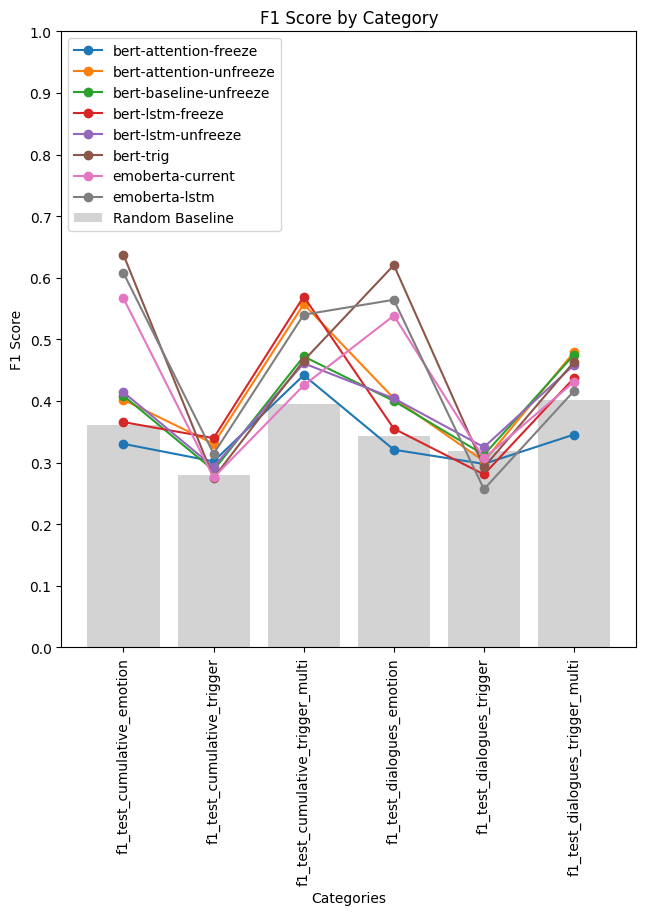

In [ ]:
baseline_freeze = test_results_aggregated.loc["bert-baseline-freeze"]


# Sample data (replace this with your actual data)
plt.figure(figsize=(10, 14))
categories = test_results.columns.tolist()
# Bar chart
plt.bar(categories, test_results_aggregated.iloc[:, test_results_aggregated.columns.get_level_values(1)=='mean'].loc['bert-baseline-freeze'].tolist(), color='lightgray', label='Random Baseline')

# Line plot
for model_name in test_results_aggregated.index.tolist():
    if model_name == "bert-baseline-freeze":
        continue
    # Get mean for the current model
    
    model_results_mean = test_results_aggregated.iloc[:, test_results_aggregated.columns.get_level_values(1)=='mean'].loc[model_name].tolist()
    plt.plot(categories, model_results_mean, marker='o', linestyle='-', label=model_name)

# plt.plot(categories, f1_score_best_list + [f1_score_best_average], marker='o', linestyle='-', color='green', label='F1 Score (Line)')


# Adding labels and title
plt.xlabel('Categories')
plt.ylabel('F1 Score')
plt.title('F1 Score by Category')
plt.ylim(0, 1)
plt.xticks(rotation=90)
# put the legend out of the figure
plt.legend(bbox_to_anchor=(0, 1), loc='upper left',)
plt.subplots_adjust(right=0.7)
plt.yticks(np.arange(0, 1.1, 0.1))

# Adding legend

# Show the plot
plt.show()

# What?

In [ ]:
# Select all the utterances that are equalt to word

word = 'i know honey, i\'m sorry.'
what_dialogues = df[df['utterances'].apply(lambda x: x.split(': ')[1].lower()) == word].index.get_level_values(0).tolist()
what_df = test_loader.dataset.data.iloc[what_dialogues]


In [ ]:
class WhatDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        return self.dataframe.iloc[index]

In [ ]:
loader = DataLoader(WhatDataset(what_df), batch_size=1, shuffle=False, collate_fn=test_loader.collate_fn)

In [ ]:
torch.backends.cudnn.deterministic = True

In [ ]:
# Load baseline model
baseline_model = load_model(models["bert-baseline-freeze"]["model_class"], "bert-baseline-freeze-seed-6", hyperparameters=models["bert-baseline-freeze"]["hyperparameters"])
baseline_model.eval()

/home/elements72/.local/lib/python3.10/site-packages/lightning/pytorch/utilities/migration/utils.py:55: The loaded checkpoint was produced with Lightning v2.1.3, which is newer than your current Lightning version: v2.1.0


Using cache of size 100000 for the embedding


BertBaseline(
  (emotion_clf): CLF(
    (fc0): Linear(in_features=768, out_features=128, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (fc1): Linear(in_features=128, out_features=128, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
    (out): Linear(in_features=128, out_features=7, bias=True)
  )
  (trigger_clf): CLF(
    (fc0): Linear(in_features=768, out_features=128, bias=True)
    (relu0): ReLU()
    (dropout0): Dropout(p=0.2, inplace=False)
    (fc1): Linear(in_features=128, out_features=128, bias=True)
    (relu1): ReLU()
    (dropout1): Dropout(p=0.2, inplace=False)
    (out): Linear(in_features=128, out_features=2, bias=True)
  )
  (encoder): BertEncoder(
    (model): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,),

In [ ]:
# Get most difficult dialogues
data = []
count = 0
for x in test_loader:
    #print(x)
    pred = baseline_model.pred(x, None, None)
    emotions_pred = pred["emotions"].tolist()
    emotions_true = x["emotions"].tolist()
    
    utterances = [item for sublist in x["utterances"] for item in sublist]
    emotions_pred = [item for sublist in emotions_pred for item in sublist]
    emotions_true = [item for sublist in emotions_true for item in sublist]
    dialog_id = [i + count for i in range(len(x["utterances"])) for _ in x['utterances'][i]]

    count += len(x['utterances'])
    
    trigger_pred = pred["triggers"].tolist()
    trigger_true = x["triggers"].tolist()
    
    trigger_pred = [item for sublist in trigger_pred for item in sublist]
    trigger_true = [item for sublist in trigger_true for item in sublist]
    
    # Utterances, emotion_pred, emotion_true are lists 
    
    data = data + list(zip(utterances, emotions_pred, emotions_true, trigger_pred, trigger_true, dialog_id))    
    

df_what_baseline = pd.DataFrame(columns=["utterances", "emotion_pred", "emotion_true", "trigger_pred", "trigger_true", "dialog_id"], data=data)
    
df_what_baseline["emotion_correct"] = df_what_baseline["emotion_pred"] == df_what_baseline["emotion_true"]
df_what_baseline["trigger_correct"] = df_what_baseline["trigger_pred"] == df_what_baseline["trigger_true"]

df_what_baseline["emotion_pred"] = df_what_baseline["emotion_pred"].apply(lambda x: emotion_encoder.classes_[x])
df_what_baseline["emotion_true"] = df_what_baseline["emotion_true"].apply(lambda x: emotion_encoder.classes_[x] if x != 7 else "<PAD>")

# Remove rows where emotion true is <PAD>
df_what_baseline = df_what_baseline[df_what_baseline["emotion_true"] != "<PAD>"]

In [ ]:
what_best_model = df[df['utterances'].apply(lambda x: x.split(': ')[1].lower()) == word]
what_best_model.drop(columns=['trigger_pred', 'trigger_true', 'trigger_correct', 'emotion_correct'], inplace=True)
what_best_model.head(3)

/tmp/ipykernel_43968/3650637752.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  what_best_model.drop(columns=['trigger_pred', 'trigger_true', 'trigger_correct', 'emotion_correct'], inplace=True)


,,utterances,emotion_pred,emotion_true
dialog_id,,,,
6,1,"Monica: I know honey, I'm sorry.",anger,sadness
7,1,"Monica: I know honey, I'm sorry.",joy,sadness
8,1,"Monica: I know honey, I'm sorry.",anger,sadness


In [ ]:
# Get what utterances
what_baseline = df_what_baseline[df_what_baseline['utterances'].apply(lambda x: x.split(': ')[1].lower()) == word]
what_baseline.drop(columns=['trigger_pred', 'trigger_true', 'trigger_correct', 'emotion_correct'], inplace=True)
# Set dialog_id column as index
what_baseline = what_baseline.set_index('dialog_id')

# Remove index level
what_baseline.head(3)

/tmp/ipykernel_43968/2706161549.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  what_baseline.drop(columns=['trigger_pred', 'trigger_true', 'trigger_correct', 'emotion_correct'], inplace=True)


,utterances,emotion_pred,emotion_true
dialog_id,,,
6,"Monica: I know honey, I'm sorry.",sadness,sadness
7,"Monica: I know honey, I'm sorry.",sadness,sadness
8,"Monica: I know honey, I'm sorry.",fear,sadness


In [ ]:
# Rename columns
what_baseline.columns = ['utterances', 'emotion_pred_baseline', 'emotion_true']
what_best_model.columns = ['utterances', 'emotion_pred_best_model', 'emotion_true']

what_baseline.reset_index(inplace=True)
what_best_model.reset_index(inplace=True)

In [ ]:
merged = pd.concat([what_baseline, what_best_model], axis=1)
# Remove duplicates
merged = merged.loc[:,~merged.columns.duplicated()]
merged.drop(columns=['level_1'], inplace=True)

In [ ]:
merged.head(100)

,dialog_id,utterances,emotion_pred_baseline,emotion_true,emotion_pred_best_model
0,6,"Monica: I know honey, I'm sorry.",sadness,sadness,anger
1,7,"Monica: I know honey, I'm sorry.",sadness,sadness,joy
2,8,"Monica: I know honey, I'm sorry.",fear,sadness,anger
3,9,"Monica: I know honey, I'm sorry.",fear,sadness,disgust
4,10,"Monica: I know honey, I'm sorry.",fear,sadness,joy
5,11,"Monica: I know honey, I'm sorry.",fear,sadness,disgust
6,12,"Monica: I know honey, I'm sorry.",fear,sadness,anger


In [ ]:
# Get the rows where the emotion prediction is different
diff_emotion = merged[merged['emotion_pred_baseline'] != merged['emotion_pred_best_model']]

In [ ]:
dialog_id = diff_emotion['dialog_id'].iloc[0]

In [ ]:
# Get the dialogues with the same dialog_id
dialog = df[df.index.get_level_values(0) == dialog_id]

In [ ]:
dialog

utterances  \
dialog_id                                                                                                                               
142       0  Phoebe: Hey Rach, wanna hear the new song I'm thinkin' of singing this afternoon? I wrote it this morning in the shower.   
          1  Rachel: Ok.                                                                                                                
          2  Terry: Uh, Rachel, sweetheart, could I see ya for a minute?                                                                
          3  Rachel: What's up?                                                                                                         
          4  Terry: F.Y.I..                                                                                                             
          5  Terry: I've decided to pay a professional musician to play in here on Sunday afternoons.                                   
          6  Terry: Her name is Stephanie... something.                                                                                 
          7  Terry: She's supposed to be very good.                                                                                     
          8  Rachel: But what about Phoebe?                                                                                             

            emotion_pred emotion_true  trigger_pred  trigger_true  \
dialog_id                                                           
142       0  joy          joy          0             0              
          1  joy          neutral      0             0              
          2  neutral      neutral      0             0              
          3  fear         neutral      0             0              
          4  joy          neutral      0             0              
          5  fear         neutral      0             1              
          6  joy          neutral      0             0              
          7  neutral      neutral      0             0              
          8  anger        surprise     0             0              

             emotion_correct  trigger_correct  
dialog_id                                      
142       0  True             True             
          1  False            True             
          2  True             True             
          3  False            True             
          4  False            True             
          5  False            False            
          6  False            True             
          7  True             True             
          8  False            True